# CLAMPS Introduction

Hi there! Thanks for your interest in data from the Collaborative Lower Atmospheric Mobile Profiling System, or CLAMPS. This Jupyter Notebook acts as an introduction to downloading data from THREDDS and making some basic CLAMPS figures. 

CLAMPS was originally envisioned as a deployable boundary layer profiling system that is able to measure profiles of temperature, water vapor, and wind in the lowest several kilometers of the atmosphere at high temporal resolution using a particular combination of instruments. This instrument suite, and more specifically, the dataset derived from these observations, allows the users to identify and quantify significant changes in the atmospheric thermodynamic or dynamic structure. The real-time and continuous observation of these atmospheric properties is useful for characterizing the pre-convection environment for research on convective systems, mesoscale dynamic studies, research on nowcasting and forecasting local weather, technique development for remote sensing, urban meteorology, air quality and chemical weather analyses, research on boundary layer evolution, and other applications. In other words, the system allows for a unique breadth of research topics and applications. At the time of CLAMPS’s inception, no comparable capability existed within the university community or NOAA/OAR, and the CLAMPS system was the first to combine two thermodynamic profiling capabilities. While the three remote sensors that make up the CLAMPS mobile facility have a significant history, integration of the three together is what makes CLAMPS unique and powerful. The CLAMPS platform is made up of three main instruments: a Doppler lidar, a microwave radiometer (MWR), and an atmospheric emitted radiance interferometer (AERI). In addition to these three, CLAMPS also supports surface meteorological observations and a balloon radiosonde system. 

If you would like to know more information about any of these instruments, please visit: https://apps.nssl.noaa.gov/CLAMPS/instrumentation.php

Additionally, if you ever have any questions, don't hesitate to contact us:

Tyler Bell (CIWRO/NSSL) -- tyler.bell@noaa.gov

Joshua Gebauer (CIWRO/NSSL) -- joshua.gebauer@noaa.gov

Elizabeth Smith (NSSL) -- elizabeth.smith@noaa.gov

Petra Klein (OU SoM) -- pkklein@ou.edu

### Required packages

Before we get in to things, we should make sure all the required packages are installed to run these notebooks. The main packages needed are:

- Siphon 
- netCDF4
- cmocean
- matplotlib
- numpy

## Accessing Data

CLAMPS data are hosted on a THREDDS data server in netCDF4 format. There are numerous ways to access data via THREDDS, but we'll be using an API call Siphon. You can find instructions for installing Siphon here: https://unidata.github.io/siphon/latest/installguide.html



In [1]:
from siphon.catalog import TDSCatalog

In order to access data, you need to open the TDS Catalog for the product you wish to view. This will give you access to all the dataset contained in the catalog. In this case, we'll grab some VAD data from the Doppler lidar. 

In [2]:
# Catalog for the CLAMPS2 VADs
catURL = "https://data.nssl.noaa.gov/thredds/catalog/FRDD/CLAMPS/clamps/clamps2/processed/clampsdlvadC2.c1/catalog.xml"

# Open the catalog
cat = TDSCatalog(catURL)

# Print some of the datasets
print(cat.datasets[:10])

[clampsdlvadC2.c1.20190919.000000.cdf, clampsdlvadC2.c1.20200823.000000.cdf, clampsdlvadC2.c1.20200824.000000.cdf, clampsdlvadC2.c1.20200825.000000.cdf, clampsdlvadC2.c1.20200826.000000.cdf, clampsdlvadC2.c1.20200827.000000.cdf, clampsdlvadC2.c1.20200828.000000.cdf, clampsdlvadC2.c1.20200829.000000.cdf, clampsdlvadC2.c1.20200830.000000.cdf, clampsdlvadC2.c1.20200831.000000.cdf]


From here we have a couple options to explore. We can either download the desired dataset (or datasets) to our local machine, or we can use THREDDS to access data remotely. So here, we'll grab the dataset for a strong low level jet that ocurred over the National Weather Center while CLAMPS was running

In [3]:
from datetime import datetime

# Date we want to grab
dt = datetime(2020, 11, 19)

# Get the dates for all the netCDF datasets
# Note the funny way I'm grabbing the date. The VAD files had a name change at one point, so this accounts for that
nc_dates = np.array([datetime.strptime(".".join(ds.split('.')[-3:-1]), "%Y%m%d.%H%M%S") for ds in cat.datasets if '.cdf' in ds])

# Find the index of the date we want
ind = np.argmin(np.abs(dt - nc_dates))

# Get the dataset
ds = cat.datasets[ind]

## Download data
Now that we have the dataset, we can download the file to our current working directory

In [4]:
# Download the dataset we identified
ds.download()


If you need to bulk download data from CLAMPS, you can just loop through the dataset objects you want to download. For example:

In [5]:
# Download the first five datasets in the catalog
for d in cat.datasets[:5]:
    print(d.name)
    d.download()

clampsdlvadC2.c1.20190919.000000.cdf
clampsdlvadC2.c1.20200823.000000.cdf
clampsdlvadC2.c1.20200824.000000.cdf
clampsdlvadC2.c1.20200825.000000.cdf
clampsdlvadC2.c1.20200826.000000.cdf


## Accessing data
Alternatively, we can work with these data straight from the server. At the moment OPENDAP isn't enabled on this THREDDS server, but we can still access these data directly using the netCDF4 library. To do this, we need to slightly modify `catURL` by replacing 'catalog' with 'dodsC' and replacing 'catalog.xml' with our dataset name

In [6]:
from netCDF4 import Dataset

# Modify catURL to get the dataset URL
dsURL = catURL.replace('catalog.xml', ds.name).replace('catalog', 'dodsC')

# Open the dataset
nc = Dataset(dsURL)

print(nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    System: CLAMPS DL
    Contact: Petra Klein (OU) or Dave Turner (NOAA)
    Date_created: 2020-11-19T01:05:03.406262
    DODS_EXTRA.Unlimited_Dimension: time
    dimensions(sizes): time(144), height(666)
    variables(dimensions): float32 height(height), int32 base_time(), float64 time_offset(time), float64 hour(time), float32 wdir(time, height), float32 wspd(time, height), float32 w(time, height), float32 rms(time, height), float32 r_sq(time, height), float32 intensity(time, height), float32 lat(time), float32 lon(time), float32 alt(time)
    groups: 


As you can see, we now access to this dataset. The code that follows contains a function for plotting a time-height figure. It also has some suggested colormaps to use with our data.

In [7]:
import cmocean
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

cmaps = {
    'w':  {'cm': 'seismic',   'label': 'vertical velocity [m/s]'},
    'ws': {'cm': 'gist_stern_r',              'label': 'windspeed [m/s]'},
    'wd': {'cm': cmocean.cm.phase,   'label': 'wind direction [deg]'},
    'pt': {'cm': cmocean.cm.thermal, 'label': 'potential temperature [C]'},
    't': {'cm': cmocean.cm.thermal, 'label': 'temperature [C]'},
    'q':  {'cm': cmocean.cm.haline_r,  'label': 'WVMR [g/kg]'},
    'dp': {'cm': cmocean.cm.haline_r,  'label': 'dewpoint [C]'},
    'rh': {'cm': cmocean.cm.haline_r,  'label': 'RH [%]'},
    'std': {'cm': cmocean.cm.thermal,  'label': 'Standard Deviation'}
}

def timeheight(time, height, data, field, ax, datemin=None, datemax=None,
                datamin=None, datamax=None, zmin=None, zmax=None, cmap=None, **kwargs):
    '''
    Produces a time height plot of a 2-D field
    :param time: Array of times (1-D or 2-D but must have same dimenstions as height)
    :param height: Array of heights (1-D or 2-D but must have same dimensions as time)
    :param data: Array of the data to plot (2-D)
    :param field: Field being plotted. Currently supported:
        'w': Vertical Velocity
        'ws': Wind Speed
        'wd': Wind Direction
        'pt': Potential Temperature
        'q':  Specific Humidity
        'dp': Dewpoint
        'rh': Relative Humidity
        'std': Standard Deviation
    :param ax: Axis to plot the data to
    :param datemin: Datetime object
    :param datemax: Datetime object
    :param datamin: Minimum value of data to plot
    :param datamax: Maximum value of data to plot
    :param zmin: Minimum height to plot
    :param zmax: Maximum height to plot
    :return:
    '''

    # Get the colormap and label of the data
    if cmap is None:
        cm, cb_label = cmaps[field]['cm'], cmaps[field]['label']
    else:
        cm, cb_label = cmap, cmaps[field]['label']

    # Convert the dates to matplolib format if not done already
    if time.ndim == 1 and height.ndim == 1:
        time = mdates.date2num(time)
        time, height = np.meshgrid(time, height)

    # Create the plot
    c = ax.pcolormesh(time, height, data, vmin=datamin, vmax=datamax, cmap=cm, **kwargs)

    # Format the colorbar
    # c.cmap.set_bad('grey', 1.0)
    cb = plt.colorbar(c, ax=ax)
    cb.set_label(cb_label)

    # Format the limits
    ax.xaxis.set_major_locator(mdates.HourLocator())
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H%M'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

    if zmin is not None and zmax is not None:
        ax.set_ylim(zmin, zmax)
    if datemin is not None and datemax is not None:
        ax.set_xlim(mdates.date2num(np.array([datemin, datemax])))

    # Set the labels
    ax.set_ylabel('Height [m]')
    ax.set_xlabel('Time [UTC]')

    return ax

def uv_from_spd_dir(speed, wdir):
    wdir = np.deg2rad(wdir)
    u = -speed * np.sin(wdir)
    v = -speed * np.cos(wdir)
    return u, v

Now lets use these functions to plot some data

<ipython-input-7-c4463bf5f29a>:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(time, height, data, vmin=datamin, vmax=datamax, cmap=cm, **kwargs)
<ipython-input-7-c4463bf5f29a>:83: RuntimeWarning: invalid value encountered in sin
  u = -speed * np.sin(wdir)
<ipython-input-7-c4463bf5f29a>:84: RuntimeWarning: invalid value encountered in cos
  v = -speed * np.cos(wdir)


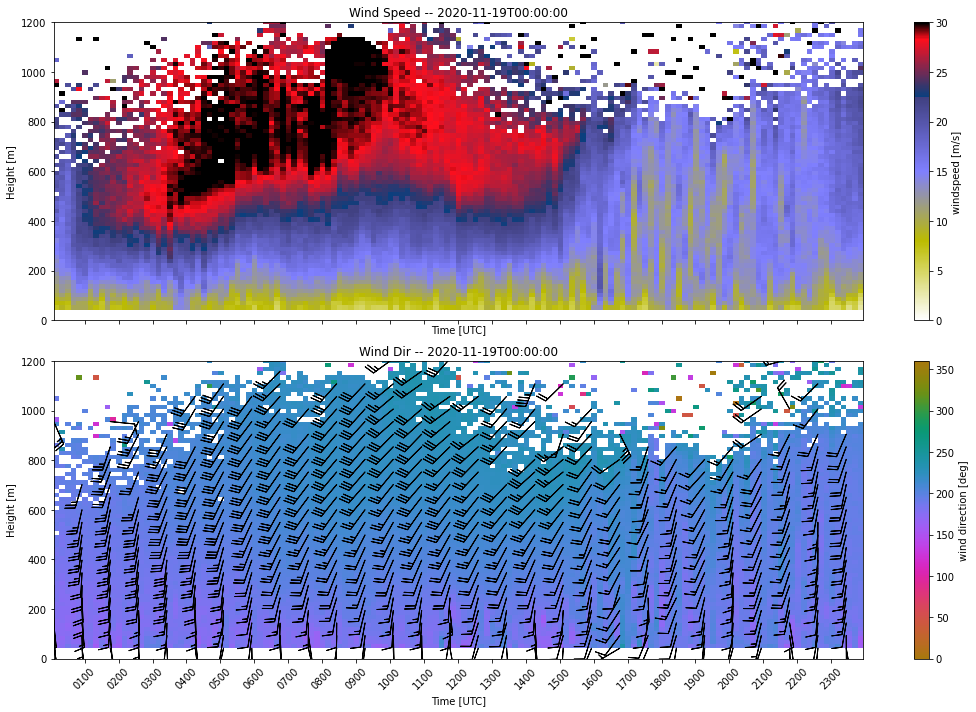

In [8]:
# Create our figure and set the width and height
fig, (wnd_spd, wnd_dir) =  plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

# Get the times and make sure they are sorted
t = [datetime.utcfromtimestamp(d) for d in (nc['base_time'][:]+nc['time_offset'][:])]

sort = np.argsort(t)
vad_times = np.array(t)[sort]
wspd = nc['wspd'][sort]
wdir = nc['wdir'][sort]
hgt = nc['height'][:] * 1000  # Convert the height to meters

# The first two gates of the Doppler lidar are usually bad data, so ignore the first two heights
hgt = hgt[2:]
wspd = wspd[:, 2:]
wdir = wdir[:, 2:]

# Grid the times and heights
time, hgt = np.meshgrid(vad_times, hgt)

# Plot the time heights
wnd_spd = timeheight(time, hgt, wspd.transpose(), 'ws', ax=wnd_spd, zmax=1200, zmin=0, datamin=0, datamax=30)
wnd_dir = timeheight(time, hgt, wdir.transpose(), 'wd', ax=wnd_dir, zmax=1200, zmin=0, datamin=0, datamax=360)

# Convert wind speed and wind direction to the u and v component of the wind
u, v = uv_from_spd_dir(wspd, wdir)

# Sometimes bad values can make it through, so lets filter out any winds > 50 m/s
u = np.where(np.abs(u) < 50, u, np.nan)
v = np.where(np.abs(v) < 50, v, np.nan)

# Plot the barbs on the wind direction axis
skipx=3
skipy=5
wnd_dir.barbs(time[::skipx, ::skipy], hgt[::skipx, ::skipy], u.transpose()[::skipx, ::skipy], v.transpose()[::skipx, ::skipy])

# Set the titles
wnd_spd.set_title("Wind Speed -- {}".format(dt.isoformat()))
wnd_dir.set_title("Wind Dir -- {}".format(dt.isoformat()))
    
plt.tight_layout()
